## Imports

In [55]:
import os, sys
import numpy as np
import pandas as pd

from lsst.daf.butler import Butler
from astropy.table import Table
from scipy.optimize import curve_fit
from scipy.stats import norm

import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm

## Prep the butler
For this example we are interested in post-ISR star flux measurements. At the time this notebook was created, the latest processing is `LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553` in `/repo/embargo`.

In [4]:
repo = '/repo/embargo'
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553',]

butler = Butler(repo, collections=collections)

### Collect the datasets
Two datasets types will be needed:
- `isolated_star_sources` to collect the star source IDs and their positions on the CCD
- `sourceTable` for the calibrated flux measurements of each source

In [7]:
def get_dataset(butler, datasetType) :
    query = butler.registry.queryDatasets(datasetType)
    queries = [q for q in query]
    dataset = pd.concat([butler.get(datasetType, dataId=q.dataId) for q in queries])
    return dataset

In [8]:
isostars = get_dataset(butler, 'isolated_star_sources')
sources  = get_dataset(butler, 'sourceTable')

We only want stars that show up in both datasets so we clear out the rest and sort by their source ID.

In [9]:
isostars = isostars[np.isin(isostars['sourceId'].values, sources.index)]
sources  = sources[np.isin(sources.index, isostars['sourceId'].values)]
isostars.sort_values(by='sourceId', inplace=True)
sources.sort_index(inplace=True)

### Get relevant exposures

Now lets restrict ourselves to looking only at exposures after 01-Jan-2023 (after the change of observing fields) and at exposures lasting between 30-35 seconds.

In [11]:
def get_exposures(butler, where, min_exp, max_exp) :
    sec_to_day = 1 / 24 / 3600
    min_exp *= sec_to_day
    max_exp *= sec_to_day
    
    exposures = np.array(list(butler.registry.queryDimensionRecords('exposure', instrument='LATISS', where=where).order_by('timespan.begin')))

    exp_times = np.array([(exp.timespan.end - exp.timespan.begin).value for exp in exposures])
    cut = [min_exp <= t <= max_exp for t in exp_times]

    return [exp for (exp, c) in zip(exposures, cut) if c]

In [12]:
where = '(exposure.day_obs>20230101)'
exposures = get_exposures(butler, where, 30, 35)

This will give many exposures, some of which may not have an isolated star source in them. So we get rid of these extra exposures.

In [13]:
def reduce_visits_to_those_in_Dataset(exposures, isostars) :
    visits_exposures = np.hstack([exp.id for exp in exposures])
    visits_isostars = isostars['visit'].values

    cut = np.isin(visits_exposures, visits_isostars)

    return [exp for (exp, c) in zip(exposures, cut) if c]

In [14]:
exposures = reduce_visits_to_those_in_Dataset(exposures, isostars)

And now we want to decide which exposures to compare. For example, we may not want to compare an exposure of a star taken in September with one taken in May due to difference in calibrations. Here we will restrict our comparisons to exposures taken on the same night, i.e. within a window of 12 hours.

In [21]:
def match_exp_within_window(exposures, window) :
    ## collect indices of the exposures to compare
    exp2comp = [np.argwhere([((exposures[j].timespan.end - exposures[i].timespan.begin).value < window)
        for j in range(i,len(exposures))])[:,0] for i in range(len(exposures))]

    ## convert those indices into exposure IDs
    exp2comp = [[exposures[i+exp].id for exp in exp2comp[i]] for i in range(len(exp2comp))]

    ## get rid of any unmatched exposures
    exp2comp = [exp for exp in exp2comp if len(exp)>1]

    return exp2comp

In [22]:
window = 0.5  #days
exp_to_compare = match_exp_within_window(exposures, window)

At this point we have all the exposures made after 01-Jan-2023 with:

* exposures times of 30-35s
* and at least one isolated star source showing up in another exposure.

Next we need to collect the positions and fluxes of each source and each source's flux variation from their "coadded" mean.

In [23]:
def nJy_to_mag(f) :
    return -2.5*np.log10(1e-9 * f) + 8.90

In [62]:
def collect_data(isostars, sources, exp2comp, band, fluxtype='ap35Flux', snr_cut=50) :
    ids_all = isostars['obj_index'].values
    snr_all  = sources[fluxtype].values / sources[f'{fluxtype}Err'].values
    mask = np.array([f == f'SDSS{band}_65mm~empty' for f in isostars['physical_filter'].values])

    x_all    = isostars['x'].values
    y_all    = isostars['y'].values
    flux_all = sources[fluxtype].values

    ids = []
    x = []
    y = []
    mag = []
    obj_mean = []

    for exp in exp2comp :
        ## MASK ON EXPOSURE AND SNR
        mask_exp = np.isin(isostars['visit'].values, exp)
        mask_exp &= np.array(snr_all > snr_cut)

        ids.append(ids_all[mask & mask_exp])

        x.append(x_all[mask & mask_exp])
        y.append(y_all[mask & mask_exp])
        
        mag.append(nJy_to_mag(flux_all[mask & mask_exp]))

        obj_mean.append(np.array([np.mean(mag[-1][ids[-1]==ID]) for ID in ids[-1]]))

    ## Some of the exposures may not have had any sources in the requested filter or none that passed the SNR cut.
    ## This would return a list of length 0 which we need to get rid of.
    ## Also, some of the exposures may not have any sources which were matched with another exposure.
    ## This would return a list of all unique elements.
    ## Since we don't care for either of these types of exposures we need to cut them out.
    cut = [not ((len(ids_i)==0) or (len(np.unique(ids_i))/len(ids_i)==1)) for ids_i in ids]

    x = np.hstack([xi for (xi,c) in zip(x, cut) if c])
    y = np.hstack([yi for (yi,c) in zip(y, cut) if c])
    
    mag = np.hstack([m for (m,c) in zip(mag, cut) if c])
    
    obj_mean = np.hstack([m for (m,c) in zip(obj_mean, cut) if c])

    ids = np.hstack([i for (i,c) in zip(ids, cut) if c])

    return x, y, mag, obj_mean, ids

In [50]:
band = 'i'
fluxtype = 'ap35Flux'

In [51]:
x, y, mag, obj_mean, ids = collect_data(isostars, sources, exp_to_compare, band, fluxtype, snr_cut=50)

## Make the star flat!
We are finally at the end where we can play with plots. Enjoy.

Here we see that there are quite a few sources with very little to no variations. These sources of course need to be looked at separately and investigated but for now we just want to look at the varying sources.

In [114]:
fig, axs = plt.subplots(1,1, figsize=(3.5,3.5));

diff_bins = np.linspace(-150,150,100)
axs.hist((mag-obj_mean)*1e3, bins=diff_bins, histtype='step', color='k', density=True);

axs.set_xlabel('$m_s - \langle m_o \\rangle$ (mmag)', loc='right');
axs.set_ylabel('Count', loc='top');
axs.set_yticklabels([]);
axs.set_yticks([]);

There seems to be a break at $\Delta m \sim 10^{-4}$mag with a non-negligible population of extremely stable sources at lower values. This seems like a reasonable place to make cut at in order to isolate the variable sources.

In [126]:
fig, axs = plt.subplots(1,1, figsize=(3.5,3.5));

diff_bins = np.logspace(-6,2,100)
axs.hist(abs(mag-obj_mean)*1e3, bins=diff_bins, histtype='step', color='k', density=True);

axs.set_xlabel('$|m_s - \langle m_o \\rangle|$ (mmag)', loc='right');
axs.set_ylabel('Count', loc='top');
axs.set_yticklabels([]);
axs.set_yticks([]);
axs.set_xscale('log');

Now with the extremely stable sources removed we can clearly see that the variable sources have a stability of around 15mmag which is not bad for an SNR cut of 50.

In [119]:
fig, axs = plt.subplots(1,1, figsize=(3.5,3.5));

cut = (abs(mag-obj_mean)*1e3 > 1e-4)

h = axs.hist((mag-obj_mean)[cut]*1e3, bins=diff_bins, histtype='step', color='k', density=True);

f = lambda x, *p: p[0]*norm.pdf(x, loc=p[1], scale=p[2])
x4plot = (diff_bins[1:] + diff_bins[:-1]) / 2
popt, pcov = curve_fit(f, x4plot, h[0], p0=[1,0,1])
axs.plot(x4plot, f(x4plot, *popt), lw=1);

leg = axs.legend([f"STD$={{{popt[2]:.2f}}}mmag$"], loc='upper left', fontsize='small',
                 labelcolor='mec', frameon=False, handlelength=0, handletextpad=0)
for item in leg.legendHandles :
    item.set_visible(False)
axs.set_xlabel('$m_s - \langle m_o \\rangle$ (mmag)', loc='right');
axs.set_ylabel('Count', loc='top');
axs.set_yticklabels([]);
axs.set_yticks([]);

/tmp/ipykernel_14077/96788197.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles :


Now lets see what these variations look like on the CCD. In principle the variations should be completely independent of their position on the CCD. What do you see? (hint: at the time of creating this notebook there is a glaring issue on the focal plane and it is not the missing vertical strips due to defect masking).

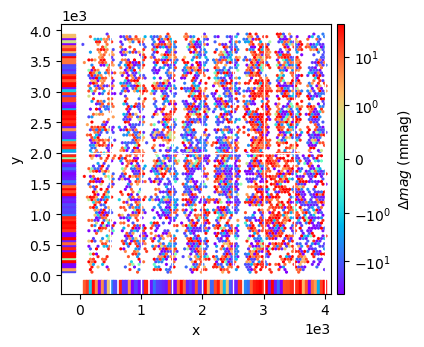

In [124]:
fig, axs = plt.subplots(1,1, figsize=(3.5,3.5))
axs.ticklabel_format(axis='both', style='scientific', scilimits=[-2,2])

p1 = axs.hexbin(x[cut], y[cut], C=(mag-obj_mean)[cut]*1e3, reduce_C_function=np.mean, gridsize=80, edgecolors='none',
        norm=mpl.colors.SymLogNorm(linthresh=1, vmin=-3*popt[2], vmax=3*popt[2]),
        cmap='rainbow', marginals=True)

[axs.axhline(i, c='w', lw=1) for i in np.linspace(0,4000, 3)]
[axs.axvline(i, c='w', lw=1) for i in np.linspace(0,4000, 9)]

axs.set_xlabel('x')
axs.set_ylabel('y')

axs.set_xlim(-300,4100)
axs.set_ylim(-300,4100)

axs.set_aspect('equal')
cax = fig.add_axes([axs.get_position().x1*1.02, axs.get_position().y0, 0.02, axs.get_position().height])
plt.colorbar(p1, cax=cax, label='$\Delta mag$ (mmag)')
